# Grunnkrets investigation

In [332]:
# Magic to automatically update imports if functions in utils are changed
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from utils import group_df, preprocess_grunnkrets_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [333]:
age_distribution = pd.read_csv("data/grunnkrets_age_distribution.csv")
age_distribution.shape

(22620, 93)

In [334]:
age_distribution.head()

,grunnkrets_id,year,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,...,age_81,age_82,age_83,age_84,age_85,age_86,age_87,age_88,age_89,age_90
0,16013117,2015,14,14,14,14,13,13,12,11,...,0,0,0,0,0,0,0,0,0,0
1,16013117,2016,10,10,10,10,10,10,9,9,...,0,0,0,0,0,0,0,0,0,0
2,11030206,2015,5,5,5,5,5,4,4,3,...,0,0,0,0,0,0,0,0,0,0
3,16011203,2016,2,2,2,2,2,3,3,3,...,1,1,1,1,1,1,1,0,0,0
4,3011601,2016,7,7,7,7,6,6,5,4,...,1,1,0,0,0,0,0,0,0,0


Look at the distribution of stores at different granularities (grunnkrets, delomrade, kommune, fylke) 

In [335]:
from sklearn.model_selection import train_test_split

stores_train = pd.read_csv("data/stores_train.csv")
stores_train, _ = train_test_split(stores_train, test_size=0.2, random_state=0)
stores_train_explore = stores_train[ ['grunnkrets_id'] ].copy()
stores_train_explore["store_count"] = 1
stores_train_explore

,grunnkrets_id,store_count
2506,6020601,1
12305,2350203,1
4142,6240307,1
8561,15040206,1
818,3012312,1
...,...,...
4859,18330207,1
3264,16017522,1
9845,15040101,1
10799,12012008,1


In [336]:
from utils import create_geographical_columns, group_df
stores_train_explore = create_geographical_columns(stores_train_explore)


In [337]:
group_df(stores_train_explore, 'grunnkrets_id')[ ['store_count'] ].value_counts()

store_count
1              1842
2               581
3               285
4               158
5               107
6                79
7                58
8                44
9                40
11               28
10               24
12               19
13               16
14               13
15               11
16               11
18               11
19                8
20                8
17                7
23                6
24                5
21                4
28                4
25                4
32                4
22                3
26                3
29                2
30                2
37                2
27                1
31                1
33                1
35                1
36                1
41                1
42                1
44                1
47                1
51                1
61                1
67                1
dtype: int64

This is very sparsely populated 

In [338]:
group_df(stores_train_explore, 'delomrade')[ ['store_count'] ].value_counts()

store_count
1              269
2              192
3              133
4              114
5               76
              ... 
48               1
27               1
42               1
40               1
205              1
Length: 65, dtype: int64

We see that each delomrade is also quite sparsely populated, except for a few

In [339]:
group_df(stores_train_explore, 'kommune')[ ['store_count'] ].value_counts()

store_count
4              39
1              30
5              29
3              26
8              26
               ..
53              1
52              1
51              1
50              1
1481            1
Length: 76, dtype: int64

We see that most "kommuner" contain few stores

In [340]:
group_df(stores_train_explore, 'fylke')[ ['store_count'] ].value_counts()

store_count
213            1
505            1
944            1
860            1
854            1
592            1
586            1
581            1
573            1
462            1
241            1
414            1
379            1
364            1
360            1
345            1
275            1
258            1
1481           1
dtype: int64

We can see that each fylke contains many stores

IDEAS: group by grunnkrets_id, first 2 digits is "fylke", first 4 corresponds to "kommune" (see https://no.wikipedia.org/wiki/Grunnkretser_i_Norge). First 6 digits are also related in some sense.

In [341]:
age_distribution = preprocess_grunnkrets_df(age_distribution, "grunnkrets_id")

In [344]:
age_list = []
for col in list(age_distribution.columns):
    if col.startswith("age"):
        _, age_num = col.split("_")
        age_list.append([int(age_num), col])
age_list = sorted(age_list, key=lambda x: (x[0]))

## Age distribution 

In [345]:
from utils import group_age_columns


new_age_distribution = group_age_columns(age_distribution_df=age_distribution, span_size=7)

In [346]:
new_age_distribution.head()

,grunnkrets_id,year,fylke,kommune,delomrade,age_0-6,age_7-13,age_14-20,age_21-27,age_28-34,age_35-41,age_42-48,age_49-55,age_56-62,age_63-69,age_70-76,age_77-83,age_84-90
6784,2190812,2015,2,219,21908,0,0,0,3,16,21,18,14,7,1,0,0,0
8175,2190914,2015,2,219,21909,29,54,46,35,23,32,44,47,33,22,12,7,5
8529,20300310,2015,20,2030,203003,2,0,6,16,24,11,7,7,7,0,0,0,0
8577,5170101,2015,5,517,51701,2,0,5,19,32,14,1,0,3,0,0,0,0
16348,2191013,2015,2,219,21910,71,70,36,44,63,76,67,50,47,37,28,25,9


This allows us to group by either "fylke", "kommune", "delomrade" or "grunnkrets"

We can now do this for all grunnkrets-related dataframes

Join in the age bins for different geographical units

In [347]:
from utils import join_grouped_df, age_bins

full_population_df = create_geographical_columns(stores_train)

full_population_df = join_grouped_df(full_population_df, new_age_distribution[age_bins(age_list, span_size=7) + ['grunnkrets_id']], 'grunnkrets_id')
full_population_df = join_grouped_df(full_population_df, new_age_distribution[age_bins(age_list, span_size=7) + ['delomrade']], 'delomrade')
full_population_df = join_grouped_df(full_population_df, new_age_distribution[age_bins(age_list, span_size=7) + ['kommune']], 'kommune')
full_population_df = join_grouped_df(full_population_df, new_age_distribution[age_bins(age_list, span_size=7) + ['fylke']], 'fylke')


### Mean and median age

In [348]:
from utils import merge_columns_mean
from utils import merge_age_columns_mean
from utils import merge_age_columns_sum

new_age_distribution2 = pd.read_csv("data/grunnkrets_age_distribution.csv")
new_age_distribution2 = preprocess_grunnkrets_df(new_age_distribution2)

Mean age for each grunnkrets

In [349]:
mean_ages_grunnkrets = merge_age_columns_mean(new_age_distribution2, 'grunnkrets_id')
mean_ages_grunnkrets.describe()

,grunnkrets_id.mean_age
count,11379.000000
mean,40.058491
std,5.000218
min,21.694444
25%,36.874665
50%,39.684000
75%,42.807146
max,81.190476


Delomrade

In [350]:
mean_ages_delomrade = merge_age_columns_mean(new_age_distribution2, 'delomrade')
mean_ages_delomrade.describe()

,delomrade.mean_age
count,1541.000000
mean,40.195220
std,3.203201
min,29.243990
25%,37.966243
50%,40.102068
75%,42.268260
max,54.132353


Kommune

In [351]:
mean_ages_kommune = merge_age_columns_mean(new_age_distribution2, 'kommune')
mean_ages_kommune.describe()

,kommune.mean_age
count,428.000000
mean,40.860425
std,2.415133
min,33.826465
25%,39.101782
50%,41.044260
75%,42.622069
max,47.307203


Fylke

In [352]:
mean_ages_fylke = merge_age_columns_mean(new_age_distribution2, 'fylke')
mean_ages_fylke.describe()

,fylke.mean_age
count,19.000000
mean,39.530080
std,1.494322
min,36.713186
25%,38.424188
50%,39.936194
75%,40.508635
max,42.140772


Do the same for total population

In [353]:
tot_pop_grunnkrets = merge_age_columns_sum(new_age_distribution2, 'grunnkrets_id')
tot_pop_grunnkrets.describe()

,grunnkrets_id.tot_pop
count,11379.00000
mean,449.91291
std,431.94708
min,59.00000
25%,167.00000
50%,308.00000
75%,575.00000
max,5993.00000


In [354]:
tot_pop_delomrade = merge_age_columns_sum(new_age_distribution2, 'delomrade')
tot_pop_delomrade

,delomrade.tot_pop
delomrade,
10101,7812
10102,9267
10103,4404
10104,4011
10105,2050
...,...
203001,387
203002,4584
203003,3642


In [355]:
tot_pop_kommune = merge_age_columns_sum(new_age_distribution2, 'kommune')
tot_pop_kommune.describe()

,kommune.tot_pop
count,428.000000
mean,11961.586449
std,38203.092998
min,201.000000
25%,1990.500000
50%,4505.500000
75%,10510.250000
max,665638.000000


In [356]:
tot_pop_fylke = merge_age_columns_sum(new_age_distribution2, 'fylke')
tot_pop_fylke.describe()

,fylke.tot_pop
count,19.000000
mean,269450.473684
std,168589.355280
min,71233.000000
25%,162694.500000
50%,229962.000000
75%,297173.500000
max,665638.000000


Merge into main df

In [357]:
full_population_df=full_population_df.merge(mean_ages_grunnkrets, how='left', right_index=True, left_on='grunnkrets_id')
full_population_df=full_population_df.merge(mean_ages_delomrade, how='left', right_index=True, left_on='delomrade')
full_population_df=full_population_df.merge(mean_ages_kommune, how='left', right_index=True, left_on='kommune')
full_population_df=full_population_df.merge(mean_ages_fylke, how='left', right_index=True, left_on='fylke')
full_population_df=full_population_df.merge(tot_pop_grunnkrets, how='left', right_index=True, left_on='grunnkrets_id')
full_population_df=full_population_df.merge(tot_pop_delomrade, how='left', right_index=True, left_on='delomrade')
full_population_df=full_population_df.merge(tot_pop_kommune, how='left', right_index=True, left_on='kommune')
full_population_df=full_population_df.merge(tot_pop_fylke, how='left', right_index=True, left_on='fylke')

/tmp/ipykernel_39061/195843144.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


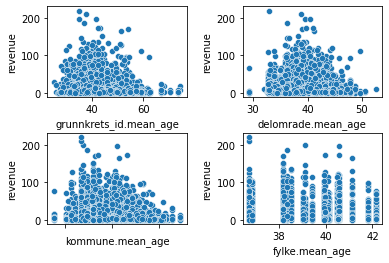

In [358]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(data=full_population_df, x="grunnkrets_id.mean_age", y="revenue")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(data=full_population_df, x="delomrade.mean_age", y="revenue")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(data=full_population_df, x="kommune.mean_age", y="revenue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(data=full_population_df, x="fylke.mean_age", y="revenue")
plt.show()

In [359]:
full_population_df[['revenue','grunnkrets_id.mean_age', 'delomrade.mean_age', 'kommune.mean_age', 'fylke.mean_age', ]].corr().head(1)

,revenue,grunnkrets_id.mean_age,delomrade.mean_age,kommune.mean_age,fylke.mean_age
revenue,1.0,-0.030029,-0.057971,-0.034496,-0.005362


In [361]:
full_population_df[['revenue']+[ f'grunnkrets_id.{i}' for i in age_bins(age_list, span_size=7)]].corr().head(1)

,revenue,grunnkrets_id.age_0-6,grunnkrets_id.age_7-13,grunnkrets_id.age_14-20,grunnkrets_id.age_21-27,grunnkrets_id.age_28-34,grunnkrets_id.age_35-41,grunnkrets_id.age_42-48,grunnkrets_id.age_49-55,grunnkrets_id.age_56-62,grunnkrets_id.age_63-69,grunnkrets_id.age_70-76,grunnkrets_id.age_77-83,grunnkrets_id.age_84-90
revenue,1.0,0.01462,0.015664,0.018087,0.00485,0.000687,0.005873,0.010822,0.009239,0.006265,-0.00417,-0.009109,-0.004204,-0.001976


In [362]:
full_population_df[['revenue']+[ f'delomrade.{i}' for i in age_bins(age_list, span_size=7)]].corr().head(1)

,revenue,delomrade.age_0-6,delomrade.age_7-13,delomrade.age_14-20,delomrade.age_21-27,delomrade.age_28-34,delomrade.age_35-41,delomrade.age_42-48,delomrade.age_49-55,delomrade.age_56-62,delomrade.age_63-69,delomrade.age_70-76,delomrade.age_77-83,delomrade.age_84-90
revenue,1.0,0.024235,0.024122,0.023133,0.011912,0.009899,0.016274,0.020793,0.019898,0.018408,0.012147,0.007343,0.007292,0.007562


In [316]:
full_population_df[['revenue']+[ f'kommune.{i}' for i in age_bins(age_list, span_size=7)]].corr().head(1)

,revenue,kommune.age_0-6,kommune.age_7-13,kommune.age_14-20,kommune.age_21-27,kommune.age_28-34,kommune.age_35-41,kommune.age_42-48,kommune.age_49-55,kommune.age_56-62,kommune.age_63-69,kommune.age_70-76,kommune.age_77-83,kommune.age_84-90
revenue,1.0,0.006465,0.007736,0.009398,0.008027,0.00537,0.005788,0.006999,0.007529,0.008076,0.008347,0.008516,0.008348,0.007773


In [317]:
full_population_df[['revenue']+[ f'fylke.{i}' for i in age_bins(age_list, span_size=7)]].corr().head(1)

,revenue,fylke.age_0-6,fylke.age_7-13,fylke.age_14-20,fylke.age_21-27,fylke.age_28-34,fylke.age_35-41,fylke.age_42-48,fylke.age_49-55,fylke.age_56-62,fylke.age_63-69,fylke.age_70-76,fylke.age_77-83,fylke.age_84-90
revenue,1.0,0.003941,0.003988,0.005117,0.006769,0.004139,0.003714,0.003678,0.003939,0.005082,0.006023,0.005752,0.006486,0.007392


/tmp/ipykernel_39061/1372027560.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


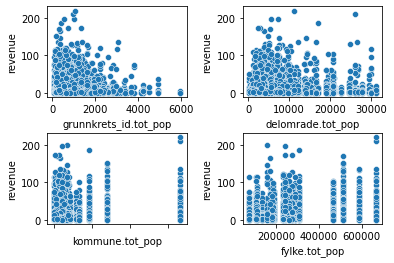

In [318]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(data=full_population_df, x="grunnkrets_id.tot_pop", y="revenue")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(data=full_population_df, x="delomrade.tot_pop", y="revenue")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(data=full_population_df, x="kommune.tot_pop", y="revenue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(data=full_population_df, x="fylke.tot_pop", y="revenue")
plt.show()

In [319]:
full_population_df[['grunnkrets_id.tot_pop', 'delomrade.tot_pop', 'kommune.tot_pop', 'fylke.tot_pop', 'revenue']].corr()

,grunnkrets_id.tot_pop,delomrade.tot_pop,kommune.tot_pop,fylke.tot_pop,revenue
grunnkrets_id.tot_pop,1.000000,0.363183,0.357638,0.292018,0.007021
delomrade.tot_pop,0.363183,1.000000,0.543831,0.481165,0.018022
kommune.tot_pop,0.357638,0.543831,1.000000,0.724911,0.007184
fylke.tot_pop,0.292018,0.481165,0.724911,1.000000,0.004849
revenue,0.007021,0.018022,0.007184,0.004849,1.000000


## Look at households

In [320]:

num_persons_df = pd.read_csv("data/grunnkrets_households_num_persons.csv")
num_persons_df.shape

(26009, 10)

In [321]:
num_persons_df.head()

,grunnkrets_id,year,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles
0,12010509,2015,0,0,4,0,0,0,0,4
1,14390206,2015,0,7,0,0,0,0,0,3
2,18040514,2015,10,0,0,0,0,0,0,7
3,18040804,2015,0,0,0,0,0,0,0,0
4,18200101,2015,0,6,0,0,0,0,0,4


In [322]:

num_persons_df.describe()

,grunnkrets_id,year,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles
count,2.600900e+04,26009.000000,26009.000000,26009.000000,26009.000000,26009.000000,26009.000000,26009.000000,26009.000000,26009.000000
mean,1.002896e+07,2015.500019,74.124149,29.244915,80.865854,88.010689,6.190396,10.003960,17.490061,80.364335
std,5.929462e+06,0.500010,96.273040,33.258452,98.161437,92.247059,10.911467,12.710166,23.411638,107.537268
min,1.010102e+06,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.320205e+06,2015.000000,17.000000,9.000000,21.000000,28.000000,0.000000,0.000000,0.000000,20.000000
50%,1.018011e+07,2016.000000,43.000000,20.000000,49.000000,58.000000,0.000000,7.000000,10.000000,44.000000
75%,1.563030e+07,2016.000000,94.000000,38.000000,104.000000,116.000000,9.000000,14.000000,24.000000,98.000000
max,2.030050e+07,2016.000000,1729.000000,497.000000,1613.000000,1066.000000,173.000000,173.000000,309.000000,1700.000000


In [323]:
new_num_persons_df = preprocess_grunnkrets_df(num_persons_df)

,grunnkrets_id,year,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles,fylke,kommune,delomrade
17250,2191402,2015,31,19,16,36,0,0,18,69,2,219,21914
19662,2191013,2015,157,62,145,122,14,18,25,105,2,219,21910
12792,2190916,2015,88,21,82,46,0,0,10,30,2,219,21909
19073,2190914,2015,55,39,159,62,7,8,23,27,2,219,21909
2117,16640121,2015,0,0,0,0,0,0,0,0,16,1664,166401
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11603,17250107,2016,36,32,54,32,0,6,8,35,17,1725,172501
11604,5450102,2016,0,7,12,20,0,8,8,27,5,545,54501
11605,4150108,2016,30,24,17,44,0,12,8,28,4,415,41501
11591,2310505,2016,34,14,47,70,0,6,8,28,2,231,23105


In [324]:
num_persons_cols = ['couple_children_0_to_5_years', 'couple_children_18_or_above', 'couple_children_6_to_17_years', 'couple_without_children', 'single_parent_children_0_to_5_years', 'single_parent_children_18_or_above', 'single_parent_children_6_to_17_years', 'singles']
full_population_df = join_grouped_df(full_population_df, new_num_persons_df[num_persons_cols+['grunnkrets_id']], 'grunnkrets_id')
full_population_df = join_grouped_df(full_population_df, new_num_persons_df[num_persons_cols+['delomrade']], 'delomrade')
full_population_df = join_grouped_df(full_population_df, new_num_persons_df[num_persons_cols+['kommune']], 'kommune')
full_population_df = join_grouped_df(full_population_df, new_num_persons_df[num_persons_cols+['fylke']], 'fylke')


In [326]:
full_population_df[['revenue']+[ f'grunnkrets_id.{i}' for i in num_persons_cols]].corr().head(1)

,revenue,grunnkrets_id.couple_children_0_to_5_years,grunnkrets_id.couple_children_18_or_above,grunnkrets_id.couple_children_6_to_17_years,grunnkrets_id.couple_without_children,grunnkrets_id.single_parent_children_0_to_5_years,grunnkrets_id.single_parent_children_18_or_above,grunnkrets_id.single_parent_children_6_to_17_years,grunnkrets_id.singles
revenue,1.0,0.008058,0.008301,0.010334,-0.010858,0.001925,0.011458,0.004419,-0.016241


In [328]:
full_population_df[['revenue']+[ f'delomrade.{i}' for i in num_persons_cols]].corr().head(1)

,revenue,delomrade.couple_children_0_to_5_years,delomrade.couple_children_18_or_above,delomrade.couple_children_6_to_17_years,delomrade.couple_without_children,delomrade.single_parent_children_0_to_5_years,delomrade.single_parent_children_18_or_above,delomrade.single_parent_children_6_to_17_years,delomrade.singles
revenue,1.0,0.024963,0.023119,0.024282,0.014731,0.011801,0.024854,0.025693,0.005292


In [329]:
full_population_df[['revenue']+[ f'kommune.{i}' for i in num_persons_cols]].corr().head(1)

,revenue,kommune.couple_children_0_to_5_years,kommune.couple_children_18_or_above,kommune.couple_children_6_to_17_years,kommune.couple_without_children,kommune.single_parent_children_0_to_5_years,kommune.single_parent_children_18_or_above,kommune.single_parent_children_6_to_17_years,kommune.singles
revenue,1.0,0.006808,0.010492,0.009157,0.00868,0.003367,0.008653,0.007297,0.006167


In [330]:
full_population_df[['revenue']+[ f'fylke.{i}' for i in num_persons_cols]].corr().head(1)

,revenue,fylke.couple_children_0_to_5_years,fylke.couple_children_18_or_above,fylke.couple_children_6_to_17_years,fylke.couple_without_children,fylke.single_parent_children_0_to_5_years,fylke.single_parent_children_18_or_above,fylke.single_parent_children_6_to_17_years,fylke.singles
revenue,1.0,0.004194,0.006281,0.004328,0.006235,0.000363,0.007542,0.003589,0.004935


In [363]:
full_population_df.columns.shape

(75,)

## Preprocessing ALL the dataframes :)

In [49]:
age_distribution = pd.read_csv("data/grunnkrets_age_distribution.csv")
households_num_persons = pd.read_csv("data/grunnkrets_households_num_persons.csv")
income_households = pd.read_csv("data/grunnkrets_income_households.csv")
norway_stripped = pd.read_csv("data/grunnkrets_norway_stripped.csv")


In [50]:
# add all dataframes to dict
grunnkrets_dfs = {
    "age_distribution" : age_distribution, 
    "households_num_persons" : households_num_persons, 
    "income_households" : income_households, 
    "norway_stripped" : norway_stripped, 
    }

In [51]:
# preprocess dataframes
for df_name, df in grunnkrets_dfs.items():
    grunnkrets_dfs[df_name] = preprocess_grunnkrets_df(df)

# group age categories and sum up values
# span_size determines how many age-columns should be grouped each time
span_size = 7 # I chose 7 because it is a prime factor of 91, and makes all spans have same size
grunnkrets_dfs["age_distribution"] = group_age_columns(age_distribution_df=grunnkrets_dfs["age_distribution"], span_size=span_size)

In [52]:
# add dataframes grouped by fylke, kommune and delomrade
for df_name, df in grunnkrets_dfs.copy().items():
    grunnkrets_dfs[df_name + "_fylke"] = group_df(df, "fylke")
    grunnkrets_dfs[df_name + "_kommune"] = group_df(df, "kommune")
    grunnkrets_dfs[df_name + "_delomrade"] = group_df(df, "delomrade")


In [53]:
grunnkrets_dfs.keys()

dict_keys(['age_distribution', 'households_num_persons', 'income_households', 'norway_stripped', 'age_distribution_fylke', 'age_distribution_kommune', 'age_distribution_delomrade', 'households_num_persons_fylke', 'households_num_persons_kommune', 'households_num_persons_delomrade', 'income_households_fylke', 'income_households_kommune', 'income_households_delomrade', 'norway_stripped_fylke', 'norway_stripped_kommune', 'norway_stripped_delomrade'])

In [54]:
grunnkrets_dfs["age_distribution"]

,grunnkrets_id,year,fylke,kommune,delomrade,age_0-6,age_7-13,age_14-20,age_21-27,age_28-34,age_35-41,age_42-48,age_49-55,age_56-62,age_63-69,age_70-76,age_77-83,age_84-90
6784,2190812,2015,2,219,21908,0,0,0,3,16,21,18,14,7,1,0,0,0
8175,2190914,2015,2,219,21909,29,54,46,35,23,32,44,47,33,22,12,7,5
8529,20300310,2015,20,2030,203003,2,0,6,16,24,11,7,7,7,0,0,0,0
8577,5170101,2015,5,517,51701,2,0,5,19,32,14,1,0,3,0,0,0,0
16348,2191013,2015,2,219,21910,71,70,36,44,63,76,67,50,47,37,28,25,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10062,1061804,2016,1,106,10618,28,26,25,42,33,31,41,49,48,56,29,8,9
10064,1063202,2016,1,106,10632,28,36,35,33,28,38,42,39,35,27,18,11,5
10065,11010402,2016,11,1101,110104,21,18,25,56,32,37,44,45,39,35,26,16,8
10038,9260106,2016,9,926,92601,30,38,26,21,24,31,35,39,42,47,26,9,5
